In [0]:
# 1. Load all three files into separate DataFrames
drivers_df = spark.read.csv("/FileStore/tables/drivers.csv", header=True, inferSchema=True)
rides_df = spark.read.csv("/FileStore/tables/rides.csv", header=True, inferSchema=True)
feedback_df = spark.read.csv("/FileStore/tables/feedback.csv", header=True, inferSchema=True)


In [0]:
# 2. Inspect schemas and verify correct data types
drivers_df.printSchema()
rides_df.printSchema()
feedback_df.printSchema()


root
 |-- driver_id: integer (nullable = true)
 |-- driver_name: string (nullable = true)
 |-- city: string (nullable = true)
 |-- experience_years: integer (nullable = true)
 |-- rating: double (nullable = true)

root
 |-- ride_id: integer (nullable = true)
 |-- driver_id: integer (nullable = true)
 |-- distance_km: integer (nullable = true)
 |-- price: integer (nullable = true)
 |-- ride_date: date (nullable = true)

root
 |-- ride_id: integer (nullable = true)
 |-- customer_feedback: string (nullable = true)



In [0]:
# 3. Identify rides with missing drivers
rides_df.join(drivers_df, "driver_id", "left_anti").show()


+---------+-------+-----------+-----+----------+
|driver_id|ride_id|distance_km|price| ride_date|
+---------+-------+-----------+-----+----------+
|        7|   1008|         11|  270|2024-02-22|
+---------+-------+-----------+-----+----------+



In [0]:
# 4. Join rides ↔ drivers
rides_with_drivers = rides_df.join(drivers_df, "driver_id", "left")
rides_with_drivers.show()

+---------+-------+-----------+-----+----------+------------+---------+----------------+------+
|driver_id|ride_id|distance_km|price| ride_date| driver_name|     city|experience_years|rating|
+---------+-------+-----------+-----+----------+------------+---------+----------------+------+
|        1|   1001|         10|  250|2024-02-01|  Arun Kumar|Bangalore|               4|   4.6|
|        2|   1002|          7|  180|2024-02-03|   Pooja Rao|  Chennai|               2|   4.3|
|        3|   1003|         15|  500|2024-02-05|Imran Sheikh|    Delhi|               6|   4.8|
|        4|   1004|          5|  120|2024-02-08| Nisha Patel|Hyderabad|               1|   4.0|
|        1|   1005|         12|  300|2024-02-10|  Arun Kumar|Bangalore|               4|   4.6|
|        5|   1006|         20|  800|2024-02-15| Rajesh Naik|   Mumbai|               8|   4.9|
|        6|   1007|          9|  230|2024-02-20| Sneha Menon|Bangalore|               3|   4.4|
|        7|   1008|         11|  270|202

In [0]:
# 5. Add column earnings_per_km
rides_with_drivers = rides_with_drivers.withColumn("earnings_per_km", 
    (rides_with_drivers.price / rides_with_drivers.distance_km))
rides_with_drivers.show()


+---------+-------+-----------+-----+----------+------------+---------+----------------+------+------------------+
|driver_id|ride_id|distance_km|price| ride_date| driver_name|     city|experience_years|rating|   earnings_per_km|
+---------+-------+-----------+-----+----------+------------+---------+----------------+------+------------------+
|        1|   1001|         10|  250|2024-02-01|  Arun Kumar|Bangalore|               4|   4.6|              25.0|
|        2|   1002|          7|  180|2024-02-03|   Pooja Rao|  Chennai|               2|   4.3|25.714285714285715|
|        3|   1003|         15|  500|2024-02-05|Imran Sheikh|    Delhi|               6|   4.8|33.333333333333336|
|        4|   1004|          5|  120|2024-02-08| Nisha Patel|Hyderabad|               1|   4.0|              24.0|
|        1|   1005|         12|  300|2024-02-10|  Arun Kumar|Bangalore|               4|   4.6|              25.0|
|        5|   1006|         20|  800|2024-02-15| Rajesh Naik|   Mumbai|         

In [0]:
# 6. Calculate total revenue per city
from pyspark.sql.functions import sum
rides_with_drivers.groupBy("city").agg(sum("price").alias("total_revenue")).show()


+---------+-------------+
|     city|total_revenue|
+---------+-------------+
|     NULL|          270|
|Bangalore|          780|
|  Chennai|          180|
|    Delhi|          500|
|   Mumbai|          800|
|Hyderabad|          120|
+---------+-------------+



In [0]:
# 7. Determine average rating by city
from pyspark.sql.functions import avg
drivers_df.groupBy("city").agg(avg("rating").alias("avg_rating")).show()


+---------+----------+
|     city|avg_rating|
+---------+----------+
|Bangalore|       4.5|
|  Chennai|       4.3|
|    Delhi|       4.8|
|   Mumbai|       4.9|
|Hyderabad|       4.0|
+---------+----------+



In [0]:
# 8. Find the top earning driver in each city using a window function
from pyspark.sql.window import Window
from pyspark.sql.functions import rank, sum

driver_earnings = rides_with_drivers.groupBy("driver_id","driver_name","city") \
    .agg(sum("price").alias("total_earnings"))

windowSpec = Window.partitionBy("city").orderBy(driver_earnings["total_earnings"].desc())

top_drivers = driver_earnings.withColumn("rank", rank().over(windowSpec)) \
    .filter("rank = 1")
top_drivers.show()


+---------+------------+---------+--------------+----+
|driver_id| driver_name|     city|total_earnings|rank|
+---------+------------+---------+--------------+----+
|        7|        NULL|     NULL|           270|   1|
|        1|  Arun Kumar|Bangalore|           550|   1|
|        2|   Pooja Rao|  Chennai|           180|   1|
|        3|Imran Sheikh|    Delhi|           500|   1|
|        4| Nisha Patel|Hyderabad|           120|   1|
|        5| Rajesh Naik|   Mumbai|           800|   1|
+---------+------------+---------+--------------+----+



In [0]:
# 9. Identify drivers with no rides
drivers_df.join(rides_df, "driver_id", "left_anti").show()


+---------+-----------+----+----------------+------+
|driver_id|driver_name|city|experience_years|rating|
+---------+-----------+----+----------------+------+
+---------+-----------+----+----------------+------+



In [0]:
# 10. Combine the feedback dataset to mark ride performance
rides_feedback = rides_with_drivers.join(feedback_df, "ride_id", "left")
rides_feedback.show()


+-------+---------+-----------+-----+----------+------------+---------+----------------+------+------------------+-----------------+
|ride_id|driver_id|distance_km|price| ride_date| driver_name|     city|experience_years|rating|   earnings_per_km|customer_feedback|
+-------+---------+-----------+-----+----------+------------+---------+----------------+------+------------------+-----------------+
|   1001|        1|         10|  250|2024-02-01|  Arun Kumar|Bangalore|               4|   4.6|              25.0|        Excellent|
|   1002|        2|          7|  180|2024-02-03|   Pooja Rao|  Chennai|               2|   4.3|25.714285714285715|             Good|
|   1003|        3|         15|  500|2024-02-05|Imran Sheikh|    Delhi|               6|   4.8|33.333333333333336|        Excellent|
|   1004|        4|          5|  120|2024-02-08| Nisha Patel|Hyderabad|               1|   4.0|              24.0|          Average|
|   1005|        1|         12|  300|2024-02-10|  Arun Kumar|Bangalor

In [0]:
# 11. Count rides by feedback category
from pyspark.sql.functions import count
feedback_df.groupBy("customer_feedback").agg(count("*").alias("ride_count")).show()


+-----------------+----------+
|customer_feedback|ride_count|
+-----------------+----------+
|          Average|         2|
|        Excellent|         3|
|             Good|         3|
+-----------------+----------+



In [0]:
# 12. Using SQL view, find cities with highest average ride price
rides_with_drivers.createOrReplaceTempView("rides_table")

spark.sql("""
    SELECT city, AVG(price) AS avg_price
    FROM rides_table
    GROUP BY city
    ORDER BY avg_price DESC
""").show()


+---------+---------+
|     city|avg_price|
+---------+---------+
|   Mumbai|    800.0|
|    Delhi|    500.0|
|     NULL|    270.0|
|Bangalore|    260.0|
|  Chennai|    180.0|
|Hyderabad|    120.0|
+---------+---------+



In [0]:
# 13. Save final combined DataFrame as rides_summary.csv in DBFS
rides_feedback.write.csv("/FileStore/tables/rides_summary.csv", header=True, mode="overwrite")

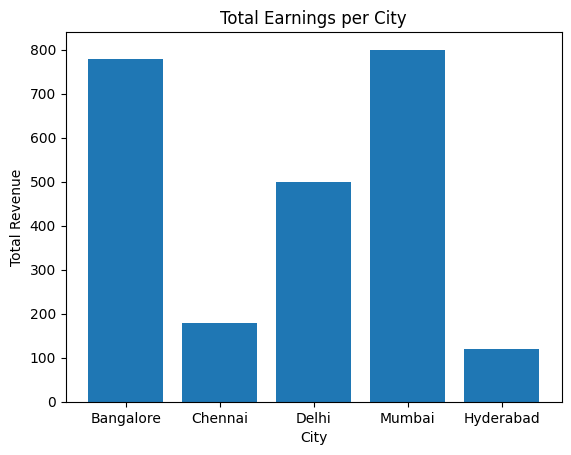

In [0]:
# 14. Plot total earnings per city as a bar chart
import matplotlib.pyplot as plt

city_earnings = rides_with_drivers.groupBy("city").agg(sum("price").alias("total_revenue")).filter("city is not null").toPandas()

plt.bar(city_earnings["city"], city_earnings["total_revenue"])
plt.xlabel("City")
plt.ylabel("Total Revenue")
plt.title("Total Earnings per City")
plt.show()
